In [1]:
# Install LSDB
%pip install -U lsdb
# Install other deps
%pip install -U light_curve[full] matplotlib


[notice] A new release of pip is available: 24.1 -> 24.2
[notice] To update, run: /astro/users/kmalanch/.virtualenvs/tape/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
/astro/users/kmalanch/.virtualenvs/tape/bin/python: No match.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import light_curve as licu
import matplotlib.pyplot as plt
import numpy as np
from dask.distributed import Client
from nested_dask import NestedFrame
from lsdb import read_hipscat, Catalog

In [3]:
from __future__ import annotations

def pack_lists(
        catalog: Catalog,
        base_columns: list[str] | None,
        list_columns: list[str] | None,
        name: str = 'nested',
):
    """Pack list-columns into nested columns
    
    Margin cache support is not implemented
    """
    new_ddf = NestedFrame.from_lists(
        catalog._ddf,
        base_columns=base_columns,
        list_columns=list_columns,
        name=name,
    )
    return Catalog(new_ddf, catalog._ddf_pixel_map, catalog.hc_structure)

In [4]:
# Path on Epyc
ALERCE_SAMPLE_PATH = '/data3/epyc/data3/hipscat/test_catalogs/alerce/alerce_sample_40k'

LC_COLUMNS = ['mjd_lc', 'fid_lc',  'magpsf', 'sigmapsf']
NONDET_COLUMNS = ['']

# Load catalog with nested lists
raw_catalog = read_hipscat(
    ALERCE_SAMPLE_PATH,
)

catalog_with_lc = pack_lists(
    raw_catalog,
    base_columns=[col for col in raw_catalog.columns if col not in LC_COLUMNS],
    list_columns=LC_COLUMNS,
    name='lc',
)

/astro/users/kmalanch/.virtualenvs/tape/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 41894 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:41961' processes=1 threads=96, memory=0.98 TiB>

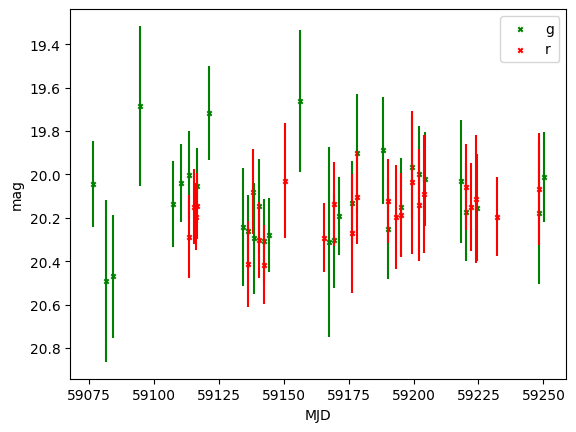

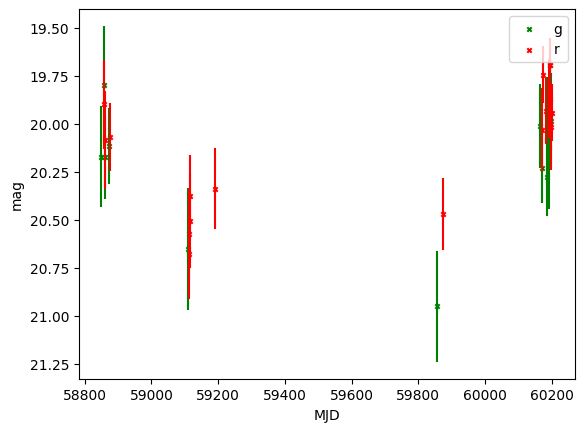

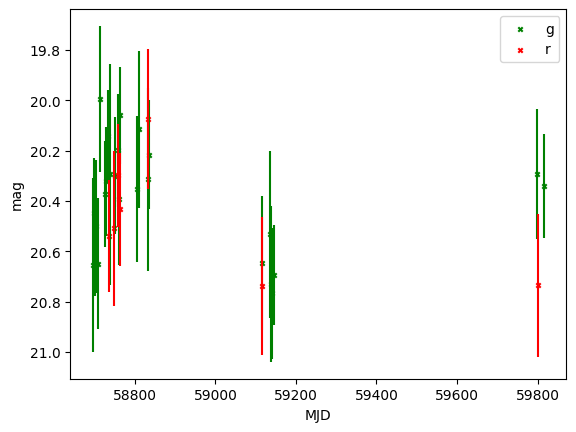

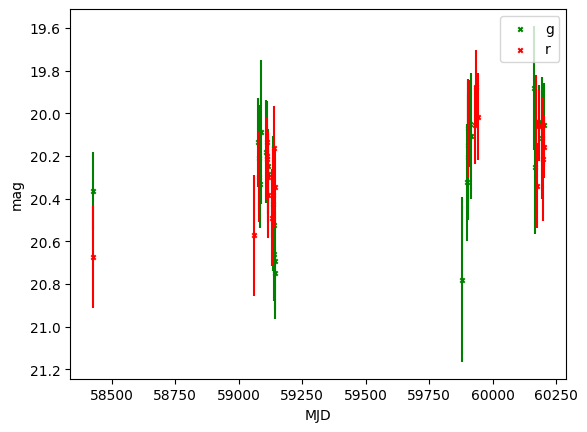

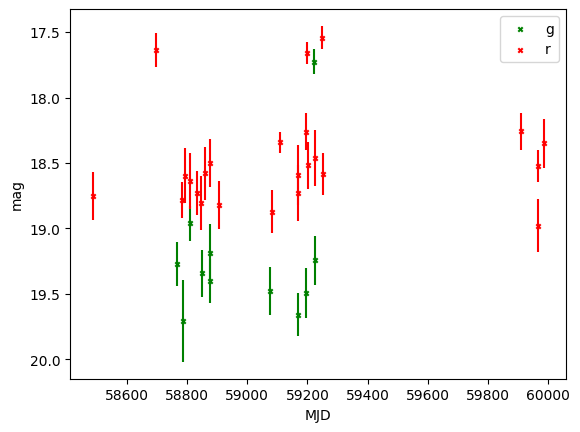

In [5]:
# "Compute" the first partition and plot few light curves

# Single partition would use the only worker anyway
with Client(n_workers=1) as client:
    display(client)
    ndf = catalog_with_lc.partitions[0].compute()

for lc in ndf['lc'].iloc[:5]:
    plt.figure()
    for fid, band in zip([1, 2], 'gr'):
        idx = lc['fid_lc'] == fid
        plt.scatter(lc['mjd_lc'][idx], lc['magpsf'][idx], label=band, color=band, marker='x', s=10)
        plt.errorbar(lc['mjd_lc'][idx], lc['magpsf'][idx], lc['sigmapsf'][idx], color=band, ls='')
    plt.legend()
    plt.xlabel('MJD')
    plt.ylabel('mag')
    plt.gca().invert_yaxis()

In [6]:
# Let's try to find a fine SN in this data

feature_extractor = licu.Extractor(
    licu.BazinFit(algorithm='ceres', ceres_niter=20, ceres_loss_reg=3),
    licu.ObservationCount(),
    licu.ReducedChi2(),
)

def extract_features(t, m, sigma):
    # Basically for meta generation
    if t.dtype.hasobject or m.dtype.hasobject or sigma.dtype.hasobject:
        return dict.fromkeys(feature_extractor.names, np.nan)
    
    # Convert magnitude to fluxes    
    flux = 10**(-0.4 * (m - 8.9))
    flux_err = 0.4 * np.log(10) * sigma * flux
    
    # Sort time and remove duplicated, required by light-curve package
    _, idx = np.unique(t, return_index=True)
    
    values = feature_extractor(t[idx], flux[idx], flux_err[idx], fill_value=np.nan)
    return dict(zip(feature_extractor.names, values))

# Use r-band only
r_band = catalog_with_lc._ddf.query('lc.fid_lc == 2')

# Extract features, Catalog.reduce is still WIP, so we use underlying dataframe directly
# https://github.com/astronomy-commons/lsdb/pull/414
features = r_band.reduce(
    extract_features,  # function
    'lc.mjd_lc', 'lc.magpsf', 'lc.sigmapsf',  # columns to use
    meta=dict.fromkeys(feature_extractor.names, float) # Dask meta
)

# Filter features to get nice light-curves
nice_features = features.query(
    'bazin_fit_reduced_chi2 > 0.8 and bazin_fit_reduced_chi2 < 3.0'
    ' and bazin_fit_rise_time > 3 and bazin_fit_rise_time < 10'
    ' and bazin_fit_fall_time < 30 and bazin_fit_fall_time > 10'
    ' and observation_count >= 10'
    ' and chi2 > 5.0'
)

In [7]:
# Join features back to the main table
sn_candidates = catalog_with_lc._ddf.join(nice_features, how='inner')

In [8]:
%%time

# I'm not sure what should be the right configuration here, but this works fine on Epyc
with Client(n_workers=10, memory_limit="5GB", threads_per_worker=2) as client:
    display(client)
    ndf = sn_candidates.compute()

ndf

<Client: 'tcp://127.0.0.1:46725' processes=10 threads=20, memory=46.57 GiB>

2024-09-20 08:55:21,297 - distributed.core - INFO - Event loop was unresponsive in Worker for 10.56s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-09-20 08:55:21,966 - distributed.core - INFO - Event loop was unresponsive in Worker for 10.25s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-09-20 08:55:22,230 - distributed.core - INFO - Event loop was unresponsive in Worker for 10.17s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-09-20 08:55:22,287 - distributed.core - INFO - Event loop was unresponsive in Worker for 11.29s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
2024-09-20 08:55:22,568 - distributed.core - INFO - Event lo

CPU times: user 1min 48s, sys: 34.1 s, total: 2min 22s
Wall time: 6min 56s


oid     mean_ra   mean_dec  \
_hipscat_index                                              
9623428969529344      ZTF20abwzqzo   41.513817   3.329906   
12812266877485056     ZTF22abmxzxm    42.60675   5.793783   
43742791112589312     ZTF21abvdazf   41.059097  10.256258   
63387948371935232     ZTF20acqlfwb   42.891443  13.021577   
119036040353677312    ZTF22abfyzir   48.358801  19.789209   
...                            ...         ...        ...   
13792177189740871680  ZTF22abbausm  318.621236  -9.047612   
13796345153687912448  ZTF22aaynpda  321.732295  -7.016983   
13798473228160598016  ZTF22abmcezf  319.982093  -6.437505   
13818584801084440576  ZTF22aamgkdw  317.380631  -7.029933   
13822530462515462144  ZTF22aaudftc  318.113332  -5.166991   

                                                                 candid  \
_hipscat_index                                                            
9623428969529344      [1333447212315015004 1333483532315015005 13365...   
12812266877485056     [2111382493315015009 2111401623315015005 21132...   
43742791112589312     [1697473413115015011 1705442483115015015 17054...   
63387948371935232     [1413317324015015032 1415283964015015037 14153...   
119036040353677312    [2085339474615015001 2085425244615015002 20864...   
...                                                                 ...   
13792177189740871680  [2055307343415015003 2055370943415015002 20572...   
13796345153687912448  [2040337975815015002 2043357745815015004 20463...   
13798473228160598016  [2105250946115015001 2107190026115015007 21121...   
13818584801084440576  [1977397565515015001 1977439255515015000 19794...   
13822530462515462144  [2025438880915015007 2027359220915015009 20293...   

                                                                    pid  \
_hipscat_index                                                            
9623428969529344      [1333447212315 1333483532315 1336511032315 133...   
12812266877485056     [2111382493315 2111401623315 2113294083315 211...   
43742791112589312     [1697473413115 1705442483115 1705474813115 170...   
63387948371935232     [1413317324015 1415283964015 1415321794015 141...   
119036040353677312    [2085339474615 2085425244615 2086427463515 208...   
...                                                                 ...   
13792177189740871680  [2055307343415 2055370943415 2057266293415 205...   
13796345153687912448  [2040337975815 2043357745815 2046358695815 205...   
13798473228160598016  [2105250946115 2107190026115 2112175636115 211...   
13818584801084440576  [1977397565515 1977439255515 1979422835515 197...   
13822530462515462144  [2025438880915 2027359220915 2029352930915 202...   

                                                          diffmaglim_lc  \
_hipscat_index                                                            
9623428969529344      [20.430056 20.6504   20.16435  19.649452 19.44...   
12812266877485056     [19.551022 19.2496   19.546438 20.35511  20.37...   
43742791112589312     [19.931095 20.742842 20.793701 20.764137 20.72...   
63387948371935232     [20.29218  20.518227 20.61483  20.51593  19.95...   
119036040353677312    [20.175499 20.391808 20.380594 20.433044 20.72...   
...                                                                 ...   
13792177189740871680  [19.994532 19.855967 20.471058 20.436352 20.40...   
13796345153687912448  [20.408583 20.552908 18.585386 19.20248  20.00...   
13798473228160598016  [19.1579   19.219225 19.937275 19.69908  20.31...   
13818584801084440576  [20.092604 20.233925 20.187037 20.658588 20.54...   
13822530462515462144  [20.132559 20.08109  20.66806  20.356771 20.61...   

                                                              isdiffpos  \
_hipscat_index                                                            
9623428969529344      [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   
12812266877485056       [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]   
437427911

https://alerce.online/object/ZTF20abwzqzo
https://alerce.online/object/ZTF22abmxzxm
https://alerce.online/object/ZTF21abvdazf
https://alerce.online/object/ZTF20acqlfwb
https://alerce.online/object/ZTF22abfyzir


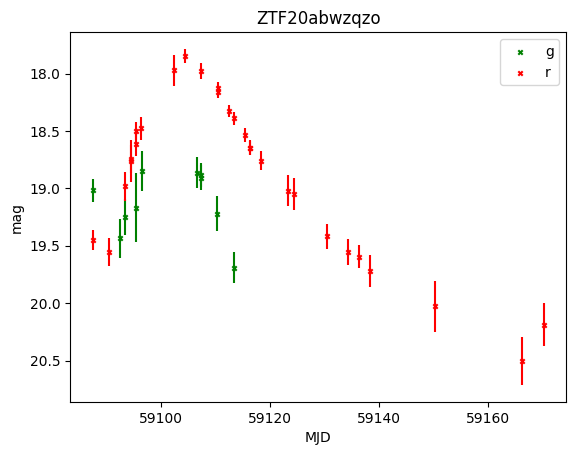

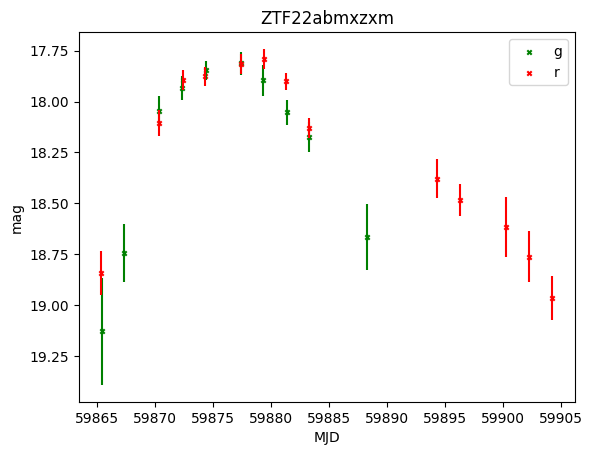

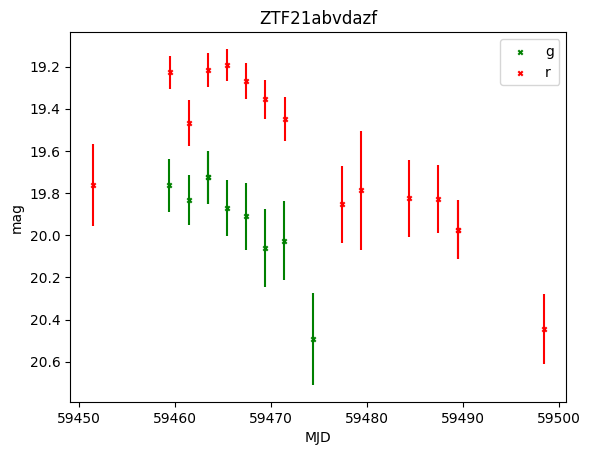

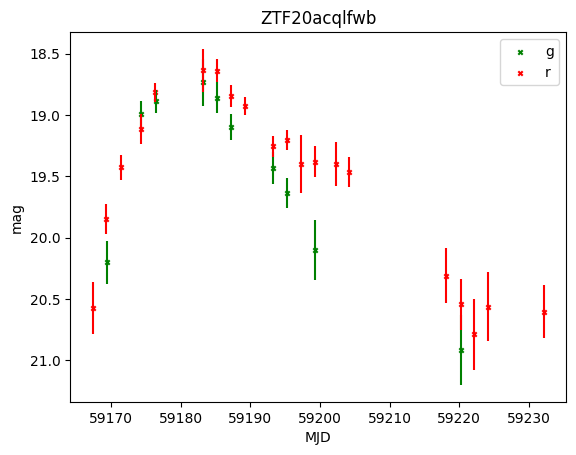

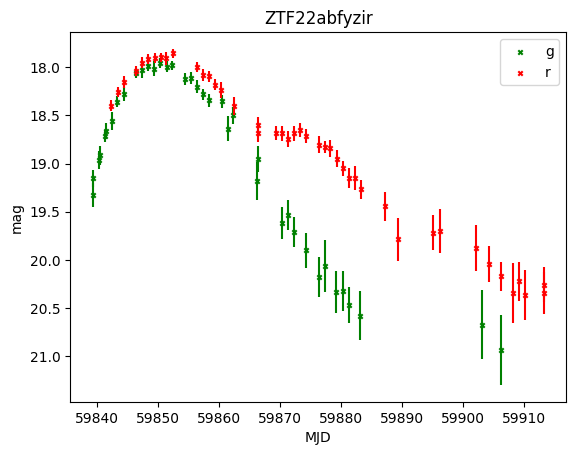

In [12]:
# Plot first five light curves

head = ndf.head(5)

for oid, lc in head[['oid', 'lc']].itertuples(index=False):
    plt.figure()
    for fid, band in zip([1, 2], 'gr'):
        idx = lc['fid_lc'] == fid
        plt.scatter(lc['mjd_lc'][idx], lc['magpsf'][idx], label=band, color=band, marker='x', s=10)
        plt.errorbar(lc['mjd_lc'][idx], lc['magpsf'][idx], lc['sigmapsf'][idx], color=band, ls='')
    plt.legend()
    plt.title(oid)
    plt.xlabel('MJD')
    plt.ylabel('mag')
    plt.gca().invert_yaxis()
    
    print(f'https://alerce.online/object/{oid}')